In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from shapely.geometry import *
from shapely.ops import nearest_points
from utils import *
import warnings
import googlemaps
import networkx as nx
import osmnx as ox
import math

In [2]:
def getDistanceRoute(G,Ids):
    distance=0
    for i in range(len(Ids)-1):
        PointA=G.nodes(data=True)[Ids[i]]
        PointB=G.nodes(data=True)[Ids[i+1]]
        dist=math.sqrt(pow(PointA['x']-PointB['x'],2)+pow(PointA['y']-PointB['y'],2))
        distance+=dist
    return distance

def getNearestNodeID(dicti,G,x,y):
    if dicti.get((x,y),None)==None:
        id=ox.distance.nearest_nodes(G,x,y)
        dicti[(x,y)]=id
        return id,dicti 
    else:
        id=dicti.get((x,y),None)
        return id,dicti

In [3]:
ox.config(log_console=True, use_cache=True)
warnings.filterwarnings("ignore")

In [4]:
crsEuc,crsDeg=getUsualCRS()
bboxEuc,bboxDeg=getUsualBbox()

Lisbon=bbox(38.8076, 38.6952, -9.0929, -9.2694)
Lisbon1=Lisbon.convertToXY()

(4694149.275033623, 4678105.154380481, -1031864.8879591699, -1012216.9978341572)


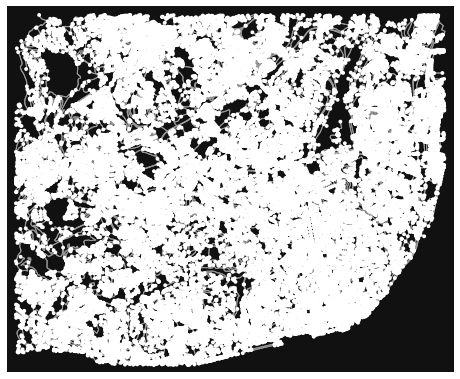

In [5]:
mode='walk'
G = ox.graph_from_bbox(38.8076,38.6952,-9.0929,-9.2694, simplify=True, network_type=mode)
fig, ax = ox.plot_graph(G)
ox.io.save_graphml(G,"../datasets/roads/roads.graphml")

In [6]:
G=ox.io.load_graphml("../datasets/roads/roads.graphml")
G=ox.projection.project_graph(G,crsEuc)

points,clusters=loadClusters("../datasets/pois/clusters/", crs=crsEuc,categories=list(taxonomy().keys()))
stops=readGeodatafromFile("../datasets/bus/Lisboa/stops.shp",crs=crsEuc)

In [10]:
squareWidth=100
squares=getPointsFromGridSearch((Lisbon1.east,Lisbon1.south,Lisbon1.west,Lisbon1.north),squareWidth,crsEuc)
neighborsNumber=2
for i in tqdm(range(len(squares))):
    nearestStop=getNNearestPoints(squares.loc[i,'geometry'].centroid, stops, 1)[0]
    squares.at[i,'stopID']=nearestStop.iloc[0]['id']
    for cat in list(taxonomy().keys()):
        clust=clusters[cat]
        neighbors=getNNearestPoints(squares.loc[i,'geometry'].centroid, clust, neighborsNumber)
        for k,neig in enumerate(neighbors):
            name="{}{}ID".format(cat[0:4],k)
            squares.at[i,name]=neig.iloc[0]['clusterID']
            
writeGeodataToGis(squares, "../datasets/acessibility/squares1.shp",crs=crsEuc)

100%|██████████| 31717/31717 [6:16:50<00:00,  1.40it/s]  


In [7]:
dictPos={}

neighborsNumber=2
squares=readGeodatafromFile("../datasets/acessibility/squares1.shp",crs=crsEuc)
for i in tqdm(range(len(squares))):
    squareLocation=squares.loc[i,'geometry'].centroid
    squareID,dictPos=getNearestNodeID(dicti=dictPos,G=G,x=squareLocation.x,y=squareLocation.y)
    busID=squares.loc[i,'stopID']
    busLocation=getCellWithValue(stops, 'id', busID, 'geometry')
    busID,dictPos=getNearestNodeID(dicti=dictPos,G=G,x=busLocation.x,y=busLocation.y)
    path=ox.distance.shortest_path(G,squareID,busID,weight='length')
    distance=getDistanceRoute(G=G,Ids=path)
    squares.at[i,'stopDist']=distance
    for cat in list(taxonomy().keys()):
        clust=clusters[cat]
        for k in range(neighborsNumber):
            name="{}{}ID".format(cat[0:4],k)
            clusterID=squares.loc[i][name]
            clusterLocation=getCellWithValue(clust, 'clusterID', clusterID, 'geometry')
            clusterID,dictPos=getNearestNodeID(dicti=dictPos,G=G,x=clusterLocation.x,y=clusterLocation.y)
            path=ox.distance.shortest_path(G,squareID,clusterID,weight='length')
            distance=getDistanceRoute(G=G,Ids=path)
            
            name1="{}{}Dist".format(cat[0:5],k)
            squares.at[i,name1]=distance

writeGeodataToGis(squares, "../datasets/acessibility/squares1.shp",crs=crsEuc)

100%|██████████| 31717/31717 [10:07:24<00:00,  1.15s/it] 
